In [ ]:
!pip install sentinelhub rasterio ipyleaflet

# Import the geojson generated by `pysheds`



In [ ]:
import geopandas as gpd
from ipyleaflet import Map, GeoJSON, basemaps
import json

SHAPE_PATH = "watershed - Ashton.geojson"  # This comes from pysheds.ipynb
river_gdf = gpd.read_file(SHAPE_PATH)
river_gdf = river_gdf.to_crs("WGS84")

data = json.load(open(SHAPE_PATH, "r"))
geo_json = GeoJSON(data=data)

min_lon, min_lat, max_lon, max_lat = (
  min(coord[0] for coord in geo_json.data['features'][0]['geometry']['coordinates'][0]),
  min(coord[1] for coord in geo_json.data['features'][0]['geometry']['coordinates'][0]),
  max(coord[0] for coord in geo_json.data['features'][0]['geometry']['coordinates'][0]),
  max(coord[1] for coord in geo_json.data['features'][0]['geometry']['coordinates'][0]),
)

center = [min_lat + ((max_lat - min_lat) / 2), min_lon + ((max_lon - min_lon) / 2)]
zoom = 13
m = Map(basemap=basemaps.OpenTopoMap, center=center, zoom=zoom)
m.add_layer(geo_json)
m

Map(center=[48.223889, -121.689213], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

# Request data

In [ ]:
from sentinelhub import (
    BBox,
    CRS,
    SentinelHubRequest,
    MimeType,
    bbox_to_dimensions,
    DataCollection,
    SentinelHubDownloadClient,
    Geometry
)

from sentinelhub import SHConfig
from PIL import Image as PILImage
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import json
from rasterio.io import MemoryFile
import datetime

config = SHConfig()
config.sh_client_id = "OUTDATED"
config.sh_client_secret = "OUTDATED"

# Configure your bounding box and coordinate reference system
bbox = BBox(bbox=[(min_lon, max_lat), (max_lon, min_lat)], crs=CRS.WGS84)

# Define the size of the image based on the desired spatial resolution
size = bbox_to_dimensions(bbox, resolution=10)

# NDSI -  Normalized Difference Snow Index
#   https://www.usgs.gov/landsat-missions/normalized-difference-snow-index
evalscript = '''
//VERSION=3
function setup() {
  return {
    input: ["B03", "B11","B04","B02","dataMask"],
     output: [
       { id: "true_color", bands: 4 },
       { id: "ndsi", bands: 4 }
     ]
  };
}

function evaluatePixel(samples) {
    let val = index(samples.B03, samples.B11);
  	let imgVals = null;
    // The library for tiffs works well only if there is only one channel returned.
    // So we encode the "no data" as NaN here and ignore NaNs on frontend.
    const indexVal = samples.dataMask === 1 ? val : NaN;

    true_color = [2.5*samples.B04, 2.5*samples.B03, 2.5*samples.B02, samples.dataMask];

    if (val>0.42)
      ndsi = [0, 0.2, 1, samples.dataMask];  // highlight snow
    else
      ndsi = true_color;

  	return {
      true_color: true_color,
      ndsi: ndsi,
    };
}
'''

def build_request(time_range):
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_range,
                mosaicking_order="leastCC",
                maxcc=0.3,  # fuck clouds
            )
        ],
        responses=[
          SentinelHubRequest.output_response('true_color', MimeType.TIFF),
          SentinelHubRequest.output_response('ndsi', MimeType.TIFF)
        ],
        # Apply the watershed mask
        geometry=Geometry(river_gdf.geometry.values[0], crs=river_gdf.crs),
        bbox=bbox,
        size=size,
        config=config,
    )

# Create the date range
start_date = datetime.date(2023, 4, 14)
end_date = datetime.date(2024, 5, 14)
assert end_date > start_date  # stuff goes wrong if not

dates = [date.strftime('%Y-%m-%d') for date in [
    start_date + datetime.timedelta(days=x) for x in range((end_date - start_date).days + 1)
    ]
]

print(
    f"Building requests for {len(dates)} dates..."
)

# Build & fetch Sentinel API requests
requests = [build_request(date) for date in dates]
requests = [request.download_list[0] for request in requests]

fetched_data = SentinelHubDownloadClient(config=config).download(
    requests, max_threads=5
)
print(
    f"Fetched {len(fetched_data)} results"
)

Fetched 397 results


# Plot results

Processed 49 images with data
5 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1000x1000 with 0 Axes>

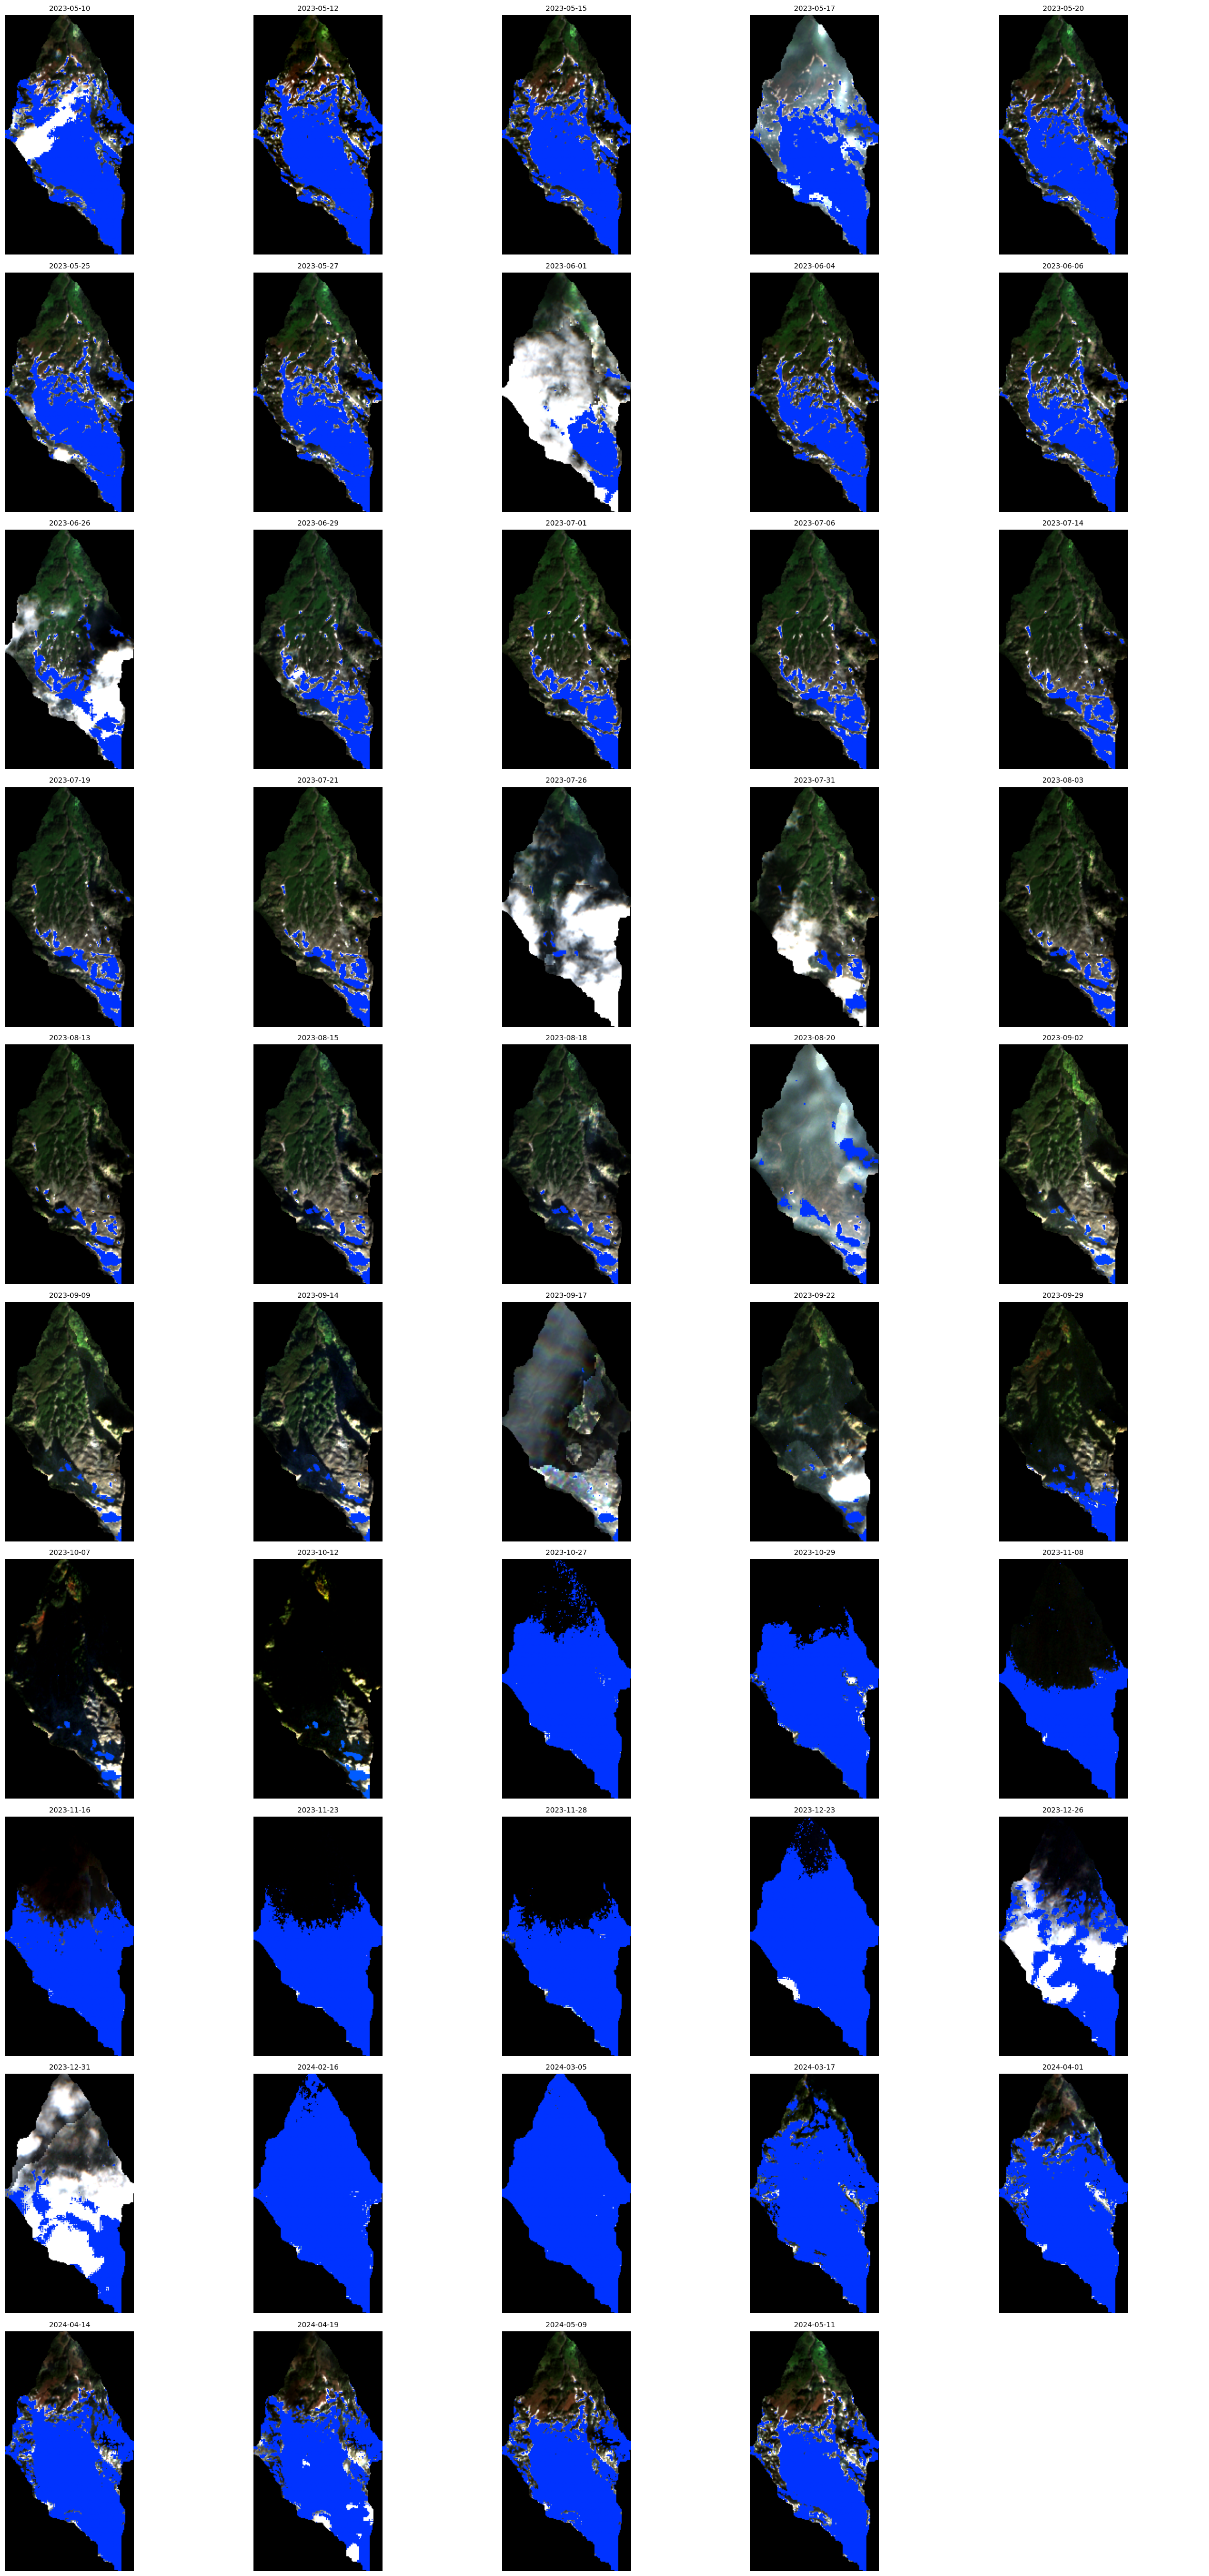

In [ ]:
to_plot=[]

# Process each returned image
for idx, responses in enumerate(fetched_data):
  image = responses['ndsi.tif']
  height, width, band_count = image.shape

  # Define the metadata
  metadata = {
      'driver': 'GTiff',
      'dtype': 'uint8',
      'width': width,
      'height': height,
      'count': band_count,
  }

  # Read the image into a rasterio object
  with MemoryFile() as memfile:
      with memfile.open(**metadata) as raster:

          # rasterio expects the array to be in the order `(bands, height, width)`
          raster.write(image.transpose(2,0,1))

          rgb_bands = raster.read([1, 2, 3])  # Read RGB bands
          datamask = raster.read(4)  # Read the datamask band

      # Check the datamask to see if there's actually any data returned
      if not np.any(datamask != 0):
        continue

      # Normalize true color image for display
      rgb_img = np.moveaxis(rgb_bands, 0, -1)
      rgb_img = rgb_img / np.percentile(rgb_img, 99)

      to_plot.append(
          (dates[idx], rgb_img)
      )

print(
    f"Processed {len(to_plot)} images with data"
)

plt.figure(figsize=(10, 10))

ncols = 5
nrows = (len(to_plot) // ncols) + 1
print(ncols,nrows)
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(5 * ncols , 5* nrows),
    subplot_kw=subplot_kw,
)

# fig.suptitle("David Creek Snowpack",fontsize=16)

for idx, image in enumerate(to_plot):
    # print(idx // ncols, idx % ncols)

    if nrows == 1:
      ax = axs[idx % ncols]
    else:
      ax = axs[idx // ncols][idx % ncols]

    ax.imshow(image[1])
    ax.set_title(image[0], fontsize=10)

plt.tight_layout()
